### Movie Recommender System

Start optim, train MSE: 27574866.30, train accuracy: 0.5950, val accuracy: 0.5799
Iteration 1, train MSE: 13421216.24, train accuracy: 0.7611, val accuracy: 0.6431
Iteration 2, train MSE: 11474959.41, train accuracy: 0.7876, val accuracy: 0.6789
Iteration 3, train MSE: 10493324.86, train accuracy: 0.8007, val accuracy: 0.6989
Iteration 4, train MSE: 10040997.98, train accuracy: 0.8069, val accuracy: 0.7084
Iteration 5, train MSE: 9792296.83, train accuracy: 0.8098, val accuracy: 0.7100
Iteration 6, train MSE: 9649312.88, train accuracy: 0.8117, val accuracy: 0.7100
Iteration 7, train MSE: 9561491.69, train accuracy: 0.8130, val accuracy: 0.7060
Iteration 8, train MSE: 9503837.41, train accuracy: 0.8138, val accuracy: 0.7117
Iteration 9, train MSE: 9463660.97, train accuracy: 0.8144, val accuracy: 0.7111
Iteration 10, train MSE: 9434168.95, train accuracy: 0.8147, val accuracy: 0.7087
Iteration 11, train MSE: 9411512.64, train accuracy: 0.8150, val accuracy: 0.7119
Iteration 12, train M

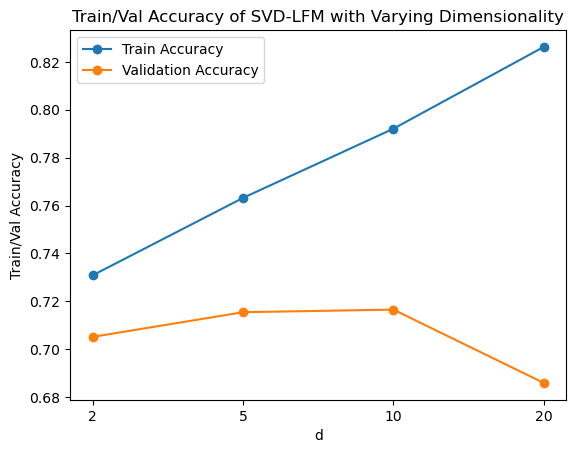

In [1]:
import os
import scipy.io
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

# Load training data from MAT file
R = scipy.io.loadmat('movie_data/movie_train.mat')['train']

# Load validation data from CSV
val_data = np.loadtxt('movie_data/movie_validate.txt', dtype=int, delimiter=',')

# Helper method to get training accuracy
def get_train_acc(R, user_vecs, movie_vecs):
    num_correct, total = 0, 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                total += 1
                if np.dot(user_vecs[i], movie_vecs[j])*R[i, j] > 0:
                    num_correct += 1
    return num_correct/total

# Helper method to get validation accuracy
def get_val_acc(val_data, user_vecs, movie_vecs):
    num_correct = 0
    for val_pt in val_data:
        user_vec = user_vecs[val_pt[0]-1]
        movie_vec = movie_vecs[val_pt[1]-1]
        est_rating = np.dot(user_vec, movie_vec)
        if est_rating*val_pt[2] > 0:
            num_correct += 1
    return num_correct/val_data.shape[0]

# Helper method to get indices of all rated movies for each user,
# and indices of all users who have rated that title for each movie
def get_rated_idxs(R):
    user_rated_idxs, movie_rated_idxs = [], []
    for i in range(R.shape[0]):
        user_rated_idxs.append(np.argwhere(~np.isnan(R[i, :])).reshape(-1))
    for j in range(R.shape[1]):
        movie_rated_idxs.append(np.argwhere(~np.isnan(R[:, j])).reshape(-1))
    return np.array(user_rated_idxs, dtype=object), np.array(movie_rated_idxs, dtype=object)

# Part (c): SVD to learn low-dimensional vector representations
def svd_lfm(R):

    # Fill in the missing values in R
    ##### TODO(c): Your Code Here #####
    R[np.isnan(R)] = 0
    # Compute the SVD of R
    ##### TODO(c): Your Code Here #####
    U, D, VT = scipy.linalg.svd(R, full_matrices=False)
    # Construct user and movie representations
    ##### TODO(c): Your Code Here #####
    user_vecs, movie_vecs = np.dot(U, np.diag(D)), VT.T
    return user_vecs, movie_vecs

# Part (d): Compute the training MSE loss of a given vectorization
def get_train_mse(R, user_vecs, movie_vecs):

    # Compute the training MSE loss
    ##### TODO(d): Your Code Here #####
    mse_loss = 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i][j]):
                mse_loss += (np.dot(user_vecs[i], movie_vecs[j]) - R[i][j])**2
    return mse_loss

# Part (e): Compute training MSE and val acc of SVD LFM for various d
d_values = [2, 5, 10, 20]
train_mses, train_accs, val_accs = [], [], []
user_vecs, movie_vecs = svd_lfm(np.copy(R))
for d in d_values:
    train_mses.append(get_train_mse(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    train_accs.append(get_train_acc(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    val_accs.append(get_val_acc(val_data, user_vecs[:, :d], movie_vecs[:, :d]))
plt.clf()
plt.plot([str(d) for d in d_values], train_mses, 'o-')
plt.title('Train MSE of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train MSE')
plt.savefig(fname='train_mses.png', dpi=600, bbox_inches='tight')
plt.clf()
plt.plot([str(d) for d in d_values], train_accs, 'o-')
plt.plot([str(d) for d in d_values], val_accs, 'o-')
plt.title('Train/Val Accuracy of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train/Val Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.savefig(fname='trval_accs.png', dpi=600, bbox_inches='tight')


# Part (f): Learn better user/movie vector representations by minimizing loss
# begin solution
best_d = 10 # TODO(f): Use best from part (e)
# end solution
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):

    # Update user_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    for i in range(len(user_vecs)):
        I = np.eye(movie_vecs.shape[1])    # Identity matrix with same features as y
        Rij_yj = np.zeros_like(movie_vecs[0])  # Same num of rows as y
        # Accessing the user_rated_idxs for j index and summing up
        for j in user_rated_idxs[i]:
            I += np.outer(movie_vecs[j], movie_vecs[j])
            Rij_yj += R[i][j] * movie_vecs[j]
        user_vecs[i] = np.dot(np.linalg.inv(I), Rij_yj)
    return user_vecs

# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):

    # Update movie_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    for j in range(len(movie_vecs)):
        I = np.eye(user_vecs.shape[1])    # Identity matrix with same features as x
        Rij_xi = np.zeros_like(user_vecs[0])   # Same num of rows as x
        # Accessing the movie_rated_idxs for i index and summing up
        for i in movie_rated_idxs[j]:
            I += np.outer(user_vecs[i], user_vecs[i])
            Rij_xi += R[i][j] * user_vecs[i]
        movie_vecs[j] = np.dot(np.linalg.inv(I), Rij_xi)
    return movie_vecs

# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')


### IM2SPAIN: Nearest Neighbors for Geo-location

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image

# Import Data
data = np.load('./im2spain/im2spain_data.npz')
# Split data
train_features = data['train_features']  # [N_train, dim] array    (27616, 768)
test_features = data['test_features']    # [N_test, dim] array     (1000, 768)
train_labels = data['train_labels']      # [N_train, 2] array of (lat, lon) coords   (27616, 2)
test_labels = data['test_labels']        # [N_test, 2] array of (lat, lon) coords    (1000, 2)
train_files = data['train_files']        # [N_train] array of strings    (27616,)
test_files = data['test_files']          # [N_test] array of strings     (1000,)

# Helper functions
def plot_data(train_feats, train_labels):
    """
    Input:
        train_feats: Training set image features
        train_labels: Training set GPS (lat, lon)
    Output:
        Displays plot of image locations, and first two PCA dimensions vs longitude
    """
    # Plot image locations (use marker='.' for better visibility)
    plt.scatter(train_labels[:, 1], train_labels[:, 0], marker=".")
    plt.title('Image Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

    # Run PCA on training_feats
    ##### TODO(a): Your Code Here #####
    transformed_feats = StandardScaler().fit_transform(train_feats)
    transformed_feats = PCA(n_components=2).fit_transform(transformed_feats)

    # Plot images by first two PCA dimensions (use marker='.' for better visibility)
    plt.scatter(transformed_feats[:, 0],     # Select first column
                transformed_feats[:, 1],     # Select second column
                c=train_labels[:, 1],
                marker='.')
    plt.colorbar(label='Longitude')
    plt.title('Image Features by Longitude after PCA')
    plt.show()

def display_images(image_paths):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths, start=1):
        image_path = f'./im2spain/im2spain_images/' + image_path
        img = mpimg.imread(image_path)
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

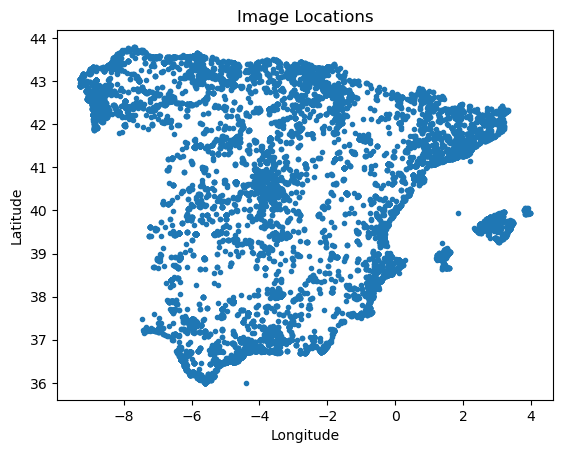

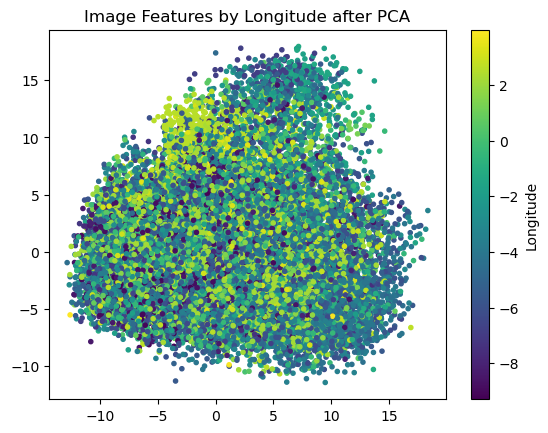

In [3]:
plot_data(train_features, train_labels)

53633239060.jpg


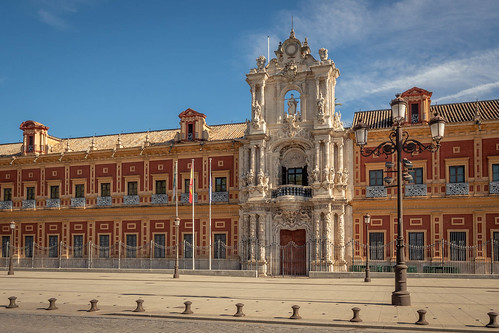

['31870484468.jpg' '4554482343.jpg' '53643099910.jpg']


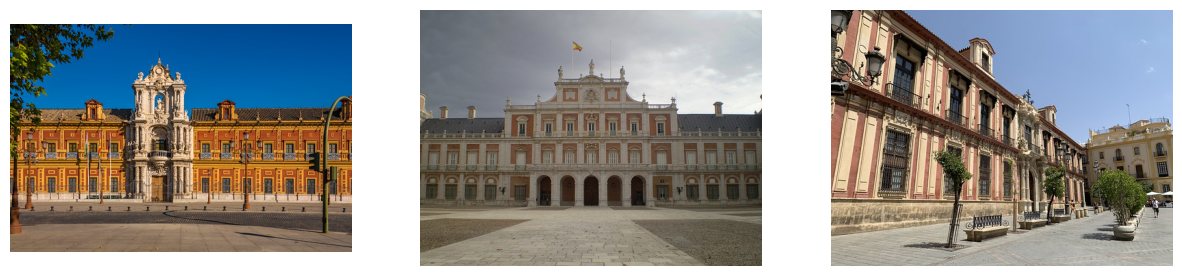

Test Coord: [37.380455 -5.993931]
Train Coord: [[[37.380424 -5.994328]
  [40.036533 -3.609201]
  [37.38637  -5.992387]]]

After I looked at these three nearest neighbors in the training set, 2 nearest neighbors are correct


In [4]:
# Find the 5 nearest neighbors of test image 53633239060.jpg
target_filename = '53633239060.jpg'

knn = NearestNeighbors(n_neighbors=3).fit(train_features)
target_index = np.where(test_files == target_filename)[0][0]

target_feature = test_features[target_index].reshape(1, -1)
distances, indices = knn.kneighbors(target_feature)

# Get filenames of the nearest neighbors
nearest_neighbor_files = train_files[indices.flatten()]

# Display the test image
print("53633239060.jpg")
display(Image(filename='./im2spain/im2spain_images/53633239060.jpg', width = 300, height = 300))

# Display the prediction images
print(nearest_neighbor_files)
display_images(nearest_neighbor_files)

# Test coord and Train coords
print(f"Test Coord: {test_labels[target_index]}")
print(f"Train Coord: {train_labels[indices]}")

print("\nAfter I looked at these three nearest neighbors in the training set, 2 nearest neighbors are correct")

In [5]:
def compute_centroid_mde(train_labels, test_labels):
    centroid = np.mean(train_labels, axis=0)
    displacements = test_labels - centroid
    # 1 degree latitude = 69 miles, 1 degree longitude = 52 miles
    displacements_miles = displacements * np.array([69, 52])
    mde = np.mean(np.sqrt(np.sum(displacements_miles**2, axis=1)))
    return mde

centroid_mde = compute_centroid_mde(train_labels, test_labels)
print(f'Naive baseline MDE: {round(centroid_mde, 2)} miles')

Naive baseline MDE: 209.86 miles


Running grid search for k (is_weighted=False)
1-NN mean displacement error (miles): 137.3
2-NN mean displacement error (miles): 133.0
3-NN mean displacement error (miles): 132.4
4-NN mean displacement error (miles): 133.5
5-NN mean displacement error (miles): 133.1
6-NN mean displacement error (miles): 135.1
7-NN mean displacement error (miles): 136.2
8-NN mean displacement error (miles): 136.6
9-NN mean displacement error (miles): 136.8
10-NN mean displacement error (miles): 138.1
20-NN mean displacement error (miles): 145.1
30-NN mean displacement error (miles): 149.5
40-NN mean displacement error (miles): 152.3
50-NN mean displacement error (miles): 154.6
100-NN mean displacement error (miles): 161.6


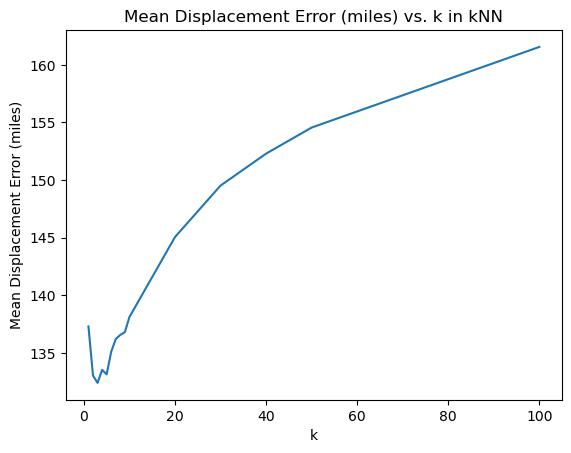

132.39832464765564

In [6]:
# Finding the best k
def grid_search(train_features, train_labels, test_features, test_labels, is_weighted=False, verbose=True):
    """
    Input:
        train_features: Training set image features
        train_labels: Training set GPS (lat, lon) coords
        test_features: Test set image features
        test_labels: Test set GPS (lat, lon) coords
        is_weighted: Weight prediction by distances in feature space

    Output:
        Prints mean displacement error as a function of k
        Plots mean displacement error vs k

    Returns:
        Minimum mean displacement error
    """
    # Evaluate mean displacement error (in miles) of kNN regression for different values of k
    # Technically we are working with spherical coordinates and should be using spherical distances, but within a small
    # region like Spain we can get away with treating the coordinates as cartesian coordinates.
    knn = NearestNeighbors(n_neighbors=100).fit(train_features)

    if verbose:
        print(f'Running grid search for k (is_weighted={is_weighted})')

    ks = list(range(1, 11)) + [20, 30, 40, 50, 100]
    mean_errors = []
    for k in ks:
        distances, indices = knn.kneighbors(test_features, n_neighbors=k)

        errors = []
        for i, nearest in enumerate(indices):
            # Evaluate mean displacement error in miles for each test image
            # Assume 1 degree latitude is 69 miles and 1 degree longitude is 52 miles
            y = test_labels[i]

            ##### TODO(d): Your Code Here #####
            nearest_train_labels = train_labels[nearest]
            weights = 1 / (distances[i] + 1e-8)
            
            if is_weighted:
                pred = np.average(nearest_train_labels, axis=0, weights=weights)
            else:
                pred = np.average(nearest_train_labels, axis=0)

            lat_err = (pred[0] - test_labels[i][0]) * 69
            long_err = (pred[1] - test_labels[i][1]) * 52
            e = np.sqrt(lat_err**2 + long_err**2)
            errors.append(e)
        
        e = np.mean(np.array(errors))
        mean_errors.append(e)
        if verbose:
            print(f'{k}-NN mean displacement error (miles): {e:.1f}')

    # Plot error vs k for k Nearest Neighbors
    if verbose:
        plt.plot(ks, mean_errors)
        plt.xlabel('k')
        plt.ylabel('Mean Displacement Error (miles)')
        plt.title('Mean Displacement Error (miles) vs. k in kNN')
        plt.show()
    
    return min(mean_errors)

grid_search(train_features, train_labels, test_features, test_labels)


The best value of k is 3 with the lowest error 132.4

#### Explain the plot in terms of bias and variance
For k=1, the model has high variance because it makes prediction based on one nearest training point, which will lead to overfitting, and it also has low bias as it hasn't seen too many training points. <br>
For k=n, the model has high bias because it takes the average of all the training points, which will always predict the same value and lead to underfitting and also it does not capture any of the complexities in the training data. It will have low variance because it will consistently predict the same value, the predictions do not vary too much between different training sets. <br>
For intermediate values of k, as k increases from 1, the variance decreases as the model becomes less sensitive to individual points in the training data, leading to smoother decision boundaries. But the bias will increase as the model becomes less flexible.

Running grid search for k (is_weighted=True)
1-NN mean displacement error (miles): 137.3
2-NN mean displacement error (miles): 131.9
3-NN mean displacement error (miles): 131.0
4-NN mean displacement error (miles): 131.9
5-NN mean displacement error (miles): 131.6
6-NN mean displacement error (miles): 133.5
7-NN mean displacement error (miles): 134.7
8-NN mean displacement error (miles): 135.1
9-NN mean displacement error (miles): 135.4
10-NN mean displacement error (miles): 136.6
20-NN mean displacement error (miles): 143.5
30-NN mean displacement error (miles): 148.0
40-NN mean displacement error (miles): 150.8
50-NN mean displacement error (miles): 153.1
100-NN mean displacement error (miles): 160.3


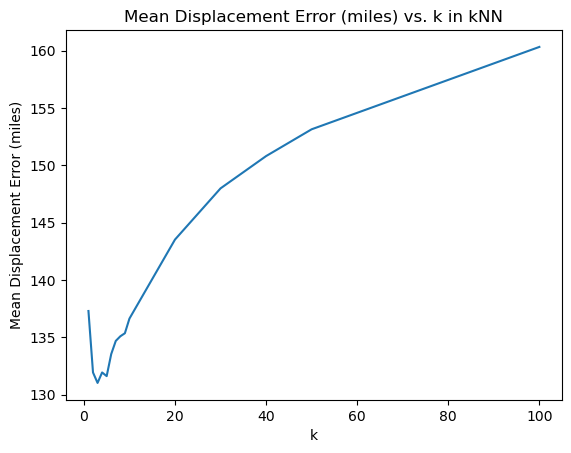

131.02949224354157

In [7]:
grid_search(train_features, train_labels, test_features, test_labels, is_weighted=True)

The best value of k is 3. The MDE is 131.03 miles. The performance compare to part (e) is slight better, each k and their MDE are generally less than part (e).

In [8]:
# Helper to find best k
def find_k(train_features, train_labels, test_features, test_labels, is_weighted=False, verbose=True):
    knn = NearestNeighbors(n_neighbors=100).fit(train_features)
    ks = list(range(1, 11)) + [20, 30, 40, 50, 100]
    mean_errors_dict = {}
    for k in ks:
        distances, indices = knn.kneighbors(test_features, n_neighbors=k)
        errors = []
        for i, nearest in enumerate(indices):
            # Evaluate mean displacement error in miles for each test image
            y = test_labels[i]
            
            nearest_train_labels = train_labels[nearest]
            weights = 1 / (distances[i] + 1e-8)
            
            if is_weighted:
                pred = np.average(nearest_train_labels, axis=0, weights=weights)
            else:
                pred = np.average(nearest_train_labels, axis=0)

            lat_err = (pred[0] - test_labels[i][0]) * 69
            long_err = (pred[1] - test_labels[i][1]) * 52
            e = np.sqrt(lat_err**2 + long_err**2)
            errors.append(e)
        
        e = np.mean(np.array(errors))
        mean_errors_dict[k] = e
    return min(mean_errors_dict, key=mean_errors_dict.get)

def compute_mde(predictions, true_labels):
    # Calculate the displacement errors in degrees
    displacement_errors = predictions - true_labels
    # Convert displacement errors to miles
    displacement_errors[:, 0] *= 69  # Latitude
    displacement_errors[:, 1] *= 52  # Longitude
    # Compute the Euclidean distance
    displacement_distances = np.sqrt(np.sum(np.square(displacement_errors), axis=1))
    mde = np.mean(displacement_distances)
    return mde

optimal_k: 7

Training set ratio: 0.1 (2761)
Linear Regression mean displacement error (miles): 183.2
kNN mean displacement error (miles): 165.0

optimal_k: 8

Training set ratio: 0.2 (5523)
Linear Regression mean displacement error (miles): 169.2
kNN mean displacement error (miles): 160.0

optimal_k: 8

Training set ratio: 0.30000000000000004 (8284)
Linear Regression mean displacement error (miles): 162.0
kNN mean displacement error (miles): 156.6

optimal_k: 5

Training set ratio: 0.4 (11046)
Linear Regression mean displacement error (miles): 158.9
kNN mean displacement error (miles): 147.6

optimal_k: 5

Training set ratio: 0.5 (13808)
Linear Regression mean displacement error (miles): 160.5
kNN mean displacement error (miles): 144.1

optimal_k: 3

Training set ratio: 0.6 (16569)
Linear Regression mean displacement error (miles): 157.8
kNN mean displacement error (miles): 144.4

optimal_k: 3

Training set ratio: 0.7000000000000001 (19331)
Linear Regression mean displacement error (m

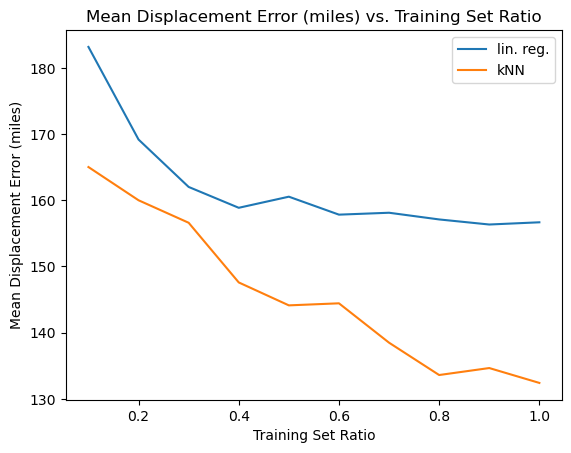

In [9]:
# Plot to compare the performance of k-NN with linear regression at different sizes of training datasets
np.random.seed(189)
mean_errors_lin = []
mean_errors_nn = []
ratios = np.arange(0.1, 1.1, 0.1)
for r in ratios:
    num_samples = int(r * len(train_features))
    ##### TODO(g): Your Code Here #####
    sampled_indices = np.random.choice(len(train_features), num_samples, replace=False)
    sampled_train_features, sampled_train_labels = train_features[sampled_indices], train_labels[sampled_indices]

    # KNN
    optimal_k = find_k(sampled_train_features, sampled_train_labels, test_features, test_labels, is_weighted=True)
    print(f"optimal_k: {optimal_k}")
    knn = NearestNeighbors(n_neighbors=optimal_k).fit(sampled_train_features)
    distances, indices = knn.kneighbors(test_features, n_neighbors=optimal_k)
    knn_predictions = np.mean(sampled_train_labels[indices], axis=1)
    e_nn = compute_mde(knn_predictions, test_labels)

    # Linear Regression
    lg = LinearRegression().fit(sampled_train_features, sampled_train_labels)
    lg_predictions = lg.predict(test_features)
    e_lin = compute_mde(lg_predictions, test_labels)
    
    mean_errors_lin.append(e_lin)
    mean_errors_nn.append(e_nn)

    print(f'\nTraining set ratio: {r} ({num_samples})')
    print(f'Linear Regression mean displacement error (miles): {e_lin:.1f}')
    print(f'kNN mean displacement error (miles): {e_nn:.1f}\n')

# Plot error vs training set size
plt.plot(ratios, mean_errors_lin, label='lin. reg.')
plt.plot(ratios, mean_errors_nn, label='kNN')
plt.xlabel('Training Set Ratio')
plt.ylabel('Mean Displacement Error (miles)')
plt.title('Mean Displacement Error (miles) vs. Training Set Ratio')
plt.legend()
plt.show()

I expect the k-NN method will continue improve with twice as much training data, because the k-NN method is a non-parametric model so the complexity can grow without bound as we increase the training set ratio, so we should expect the k-NN to coninute improving.